## Rayleigh correction of the TOA measurements from PACE instruments

**Authors:** Kamal Aryal (UMBC), Pengwang Zhai (UMBC)

## Summary
This notebook is used to do Rayleigh correction for TOA reflectances obtained from PACE instruments using a nerual network (NN) trained model. 
- The NN model is adopted from atmospheric correction module of FastMAPOL/component retrieval algorithm (Aryal et al., 2024). The rayleigh signal is obtained by setting input aerosol and surface parameters to a very low number.
- **Inputs:** Viewing geometry and atmospheric parameters (Surface pressure and Ozone).
- **Neural Network Output:** Rayleigh reflectance at 13 discrete wavelengths (385–870 nm).
- **Interpolation:** Rayleigh reflectance is interpolated to a fine wavelength grid using the physical relation R(λ) = c / λ⁴.
- **Scaling factor \( c \):** Computed by least squares fitting to match the neural network output.



This notebook highlights the importance of Rayleigh correction in atmospheric and ocean color remote sensing.
It uses a neural network trained model to predict rayleigh reflectances at 13 discrete wavelengths.
The NN models is adopted from FastMAPOL/component retrieval algorithm (Aryal et al., 2024). The NN model was originally designed for atmospheric correction of multiangle intensity mesurements.


## Learning Objectives
By the end of this notebook you will be familiar about:
- The NN training process for Rayleigh correction.
- How to use developed model to do rayleigh correction of PACE instruments measurement.
- The importance of Rayleigh correction in ocean color remote sensing.

## 1. Setup
Import all of the packages used in this notebook. 

In [15]:
import sys
import torch
import earthaccess

sharedpath='./'
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
from scipy.signal import convolve2d
from scipy import ndimage
import pickle
import types

Running on the CPU


## 2. Neural network model class used during training
- Here, we load all necessary classes and functions used during neural network model training.  
- To keep the workflow lightweight, only the essential modules required for the model’s forward computation are recreated here.  
- This avoids the need to upload the entire retrieval algorithm which the neural network was part of.

In [16]:
class Net3L(torch.nn.Module):
    def __init__(self, n_feature, n_hidden1,n_hidden2, n_hidden3, n_output):
        super(Net3L, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)   # hidden layer
        self.hidden3 = torch.nn.Linear(n_hidden2, n_hidden3)
        self.predict = torch.nn.Linear(n_hidden3, n_output)   # output layer
    def forward(self, x):
        x = torch.nn.LeakyReLU()(self.hidden1(x))     # activation function for hidden layers
        x = torch.nn.LeakyReLU()(self.hidden2(x))
        x = torch.nn.LeakyReLU()(self.hidden3(x))
        x = self.predict(x)
        return x

fn = types.SimpleNamespace(Net3L=Net3L)

def normalize(x,xmin1,xmax1,xmean1, xstd1, option=1):
    if(option==1):
        x=(x-xmin1)/(xmax1-xmin1)
    elif(option==4):
        x=x       
    return x

def inv_normalize(x, xmin1, xmax1, xmean1, xstd1, option=1):
    if(option==1):
        x=x*(xmax1-xmin1)+xmin1

    elif(option==4):
        x=x
    return x
ftool = types.SimpleNamespace(
    normalize=normalize,
    inv_normalize=inv_normalize
)

class nn_model():
    def __init__(self, info, nv, act,
                 learning_rate, batch_size, epochs,
                 nn_state_dict, train1, test_loss1, test_loss2):
        
        self.info = info
        self.nv = nv
        self.activation = act
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs

        self.test_loss1 = test_loss1
        self.test_loss2 = test_loss2

        self.xlabelv = train1.xv_df.keys()
        self.ylabelv = train1.yv_df.keys()

        self.glintmask = train1.glintmask
        self.name = train1.name
        self.xv_normalize_option = train1.xv_normalize_option
        self.yv_normalize_option = train1.yv_normalize_option

        self.xmin = train1.xmin
        self.xmax = train1.xmax
        self.ymin = train1.ymin
        self.ymax = train1.ymax

        self.xmean = train1.xmean
        self.xstd = train1.xstd
        self.ymean = train1.ymean
        self.ystd = train1.ystd

        nx = len(self.xlabelv)
        ny = len(self.ylabelv)

        self.nn = fn.Net3L(nx, nv[0], nv[1], nv[2], ny)
        self.nn.load_state_dict(nn_state_dict())

        self.xv_range_df = train1.xv_range_df
        self.angle_labelv = ['zen', 'az', 'solzen']
        if self.angle_labelv[0] in self.xv_range_df.keys():
            self.angle_range_df = self.xv_range_df[self.angle_labelv]
            self.coeff_range_df = self.xv_range_df.drop(columns=self.angle_labelv)
        else:
            print("No angles in training data")

    def forward(self, device, xpv):
        xpv1 = ftool.normalize(xpv, self.xmin.values, self.xmax.values,
                               self.xmean.values, self.xstd.values, self.xv_normalize_option)
        output = self.nn(torch.Tensor(xpv1).to(device)).cpu().data.numpy()
        return ftool.inv_normalize(output,
                                   self.ymin.values, self.ymax.values,
                                   self.ymean.values, self.ystd.values, self.yv_normalize_option)
# Recreate modules which were in original FastMAPOL/component algorithm 
sys.modules['fastmapol'] = types.ModuleType('fastmapol')
sys.modules['fastmapol.train'] = types.ModuleType('train')
sys.modules['fastmapol.net'] = types.ModuleType('net')
sys.modules['fastmapol.tool'] = types.ModuleType('tool')


sys.modules['fastmapol.train'].nn_model = nn_model
sys.modules['fastmapol.net'].Net3L = Net3L
sys.modules['fastmapol.tool'].normalize = normalize
sys.modules['fastmapol.tool'].inv_normalize = inv_normalize
#sys.modules['fastmapol.train'].nn_model = nn_model

## 3. Functions to load L1C and ancilliary data
- Here, we define functions to load L1C data and ancilliary data.
- The viewing geometry are changed according to convention used in NN training.

In [17]:

def anc_data_reader(file):
    ds1 = xr.open_dataset(file)
    lat = ds1['latitude'].values
    lon = ds1['longitude'].values
    o3 = ds1['TO3'].values/345.23947 #divided by standard US atm, as in training of FastMAPOL/component's neural network
    rh = ds1['RH'].values[0,:,:]
    ps = ds1['SLP'].values/100
    return fill_nearest(o3), fill_nearest(ps)

def l1c_data_reader(file):    
    ds1 = xr.open_dataset(file, group='geolocation_data')
    ds1s = xr.open_dataset(file, group='sensor_views_bands')
    ds1o = xr.open_dataset(file, group='observation_data',mask_and_scale=True)
    
    lat = ds1['latitude'].values
    lon = ds1['longitude'].values
    
    wavelengths = ds1s['intensity_wavelength'].values[0]
    intensity = ds1o['i'].values[:,:,:,:]
    f0 = ds1s['intensity_f0'].values[0]
    
    solzen = ds1['solar_zenith_angle'].values[:,:,:]
    solzen1=np.reshape(solzen,(*solzen.shape,1))* np.ones((1, 1,1, intensity.shape[3]))
    ref=np.pi*intensity/(np.cos(solzen1*np.pi/180.0)*f0)
    
    zen = ds1['sensor_zenith_angle'].values[:,:,:]
    az0 = ds1['sensor_azimuth_angle'].values[:,:,:]
    solaz = ds1['solar_azimuth_angle'].values [:,:,:]   
    az=set_az(set_az0(az0, solaz, flag_bin2sun=True)) 

    idx_wv1 = np.argmin(np.abs(wavelengths - 360))
    idx_wv2 = np.argmin(np.abs(wavelengths - 871))   
    return lat,lon,solzen,ref[:,:,:,idx_wv1:idx_wv2],wavelengths[idx_wv1:idx_wv2],zen,az

def l1c_data_reader1(file):
    ds1= xr.open_dataset(file)
    datatree = xr.open_datatree(file)
    ds1 = xr.merge(datatree.to_dict().values())
    lat = ds1['latitude'].values
    lon = ds1['longitude'].values
    
    wavelengths = ds1['intensity_wavelength'].values[0]
    intensity = ds1['i'].values[:,:,:,:]
    f0 = ds1['intensity_f0'].values[0]
    
    solzen = ds1['solar_zenith_angle'].values[:,:,:]
    solzen1=np.reshape(solzen,(*solzen.shape,1))* np.ones((1, 1,1, intensity.shape[3]))
    ref=np.pi*intensity/(np.cos(solzen1*np.pi/180.0)*f0)
    
    zen = ds1['sensor_zenith_angle'].values[:,:,:]
    az0 = ds1['sensor_azimuth_angle'].values[:,:,:]
    solaz = ds1['solar_azimuth_angle'].values [:,:,:]   
    az=set_az(set_az0(az0, solaz, flag_bin2sun=True)) 

    idx_wv1 = np.argmin(np.abs(wavelengths - 360))
    idx_wv2 = np.argmin(np.abs(wavelengths - 871)) 
    
    return lat,lon,solzen,ref[:,:,:,idx_wv1:idx_wv2],wavelengths[idx_wv1:idx_wv2],zen,az


def fill_nearest(arr):
    # This function is used to fill the ancilliary data in missing pixels from neighboring pixels.
    nan_mask = np.isnan(arr)
    arr_filled = np.copy(arr)
    arr_filled[nan_mask] = 0 

    # Perform nearest neighbor interpolation to fill NaNs
    nearest_idx = ndimage.distance_transform_edt(nan_mask, return_distances=False, return_indices=True)
    filled_arr = arr_filled[tuple(nearest_idx)]

    return filled_arr


def set_az0(az, solaz, flag_bin2sun=True):
    """Compute azimuth angle for the ray
    Note:
    bin2sun, used in pace l1c convention
    az0: in the range of [0,360]
    az: in the range of [0,180]
    """
    #
    if(flag_bin2sun):
        #bin2sun, used in pace l1c convention
        tmp1=az-solaz+180.0
    else:
        #sun2bin direction
        tmp1=az-solaz

    tmp1[tmp1>360]=tmp1[tmp1>360]-360
    tmp1[tmp1<0]=-tmp1[tmp1<0]
    return tmp1

def set_az(az0):
    """
    compute the az which will be used in NN
    ensure that phi is between 0-180
    """
    az = az0.copy()
    az[az<0.0] += 360.0
    az[az>180.0] = 360.0 - az[az>180.0]
    return az
    


def rgb_image(ax,ref,wavelengths):
    def find_closest(wavelength_array, target_nm):
        return np.argmin(np.abs(wavelength_array - target_nm))
    
    idx_blue = find_closest(wavelengths, 440)
    idx_green = find_closest(wavelengths, 550)
    idx_red = find_closest(wavelengths, 670)    

    R = ref[:, :,idx_red]
    G = ref[:, :,idx_green]
    B = ref[ :, :,idx_blue]
            
    def color_scaling(R, G, B):
        # Stack
        rgb = np.stack([R, G, B], axis=-1)
        # Normalize

        rgb = np.clip(rgb / 0.4, 0, 1)  
        # Gamma scaling
        rgb = rgb** (1 /2.2)#gamma  scaling
        return rgb
       
    rgb = color_scaling(R, G, B) 

    ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m', linewidth=0.5)
    ax.gridlines(draw_labels=True, color='gray', linewidth=0.3)

    ax.pcolormesh(lon, lat, rgb,
              transform=ccrs.PlateCarree(), shading='auto')

## 3. Function to load NN model

In [18]:
def load_nn(device,modelpath):
    nn_path=sharedpath+'RayleighNN_FastMAPOL_component.pk'
    nn=pickle.load(open(nn_path,'rb'))
    nn.nn.to(device)    
    return nn

### 4. Understanding the trained model

In [19]:
nn=load_nn(device,modelpath)

print(nn.activation)
print(nn.name)
print(nn.nv)
print(nn.xlabelv)

LeakyReLU
refas
[600, 300, 150]
Index(['zen', 'az', 'solzen', 'wndspd', 'aod', 'alh', 'fmf', 'ss', 'fnai',
       'bc', 'brc', 'rh', 'o3', 'ps'],
      dtype='object')


## 5. Functions to create input vector for Neural network and get Rayleigh reflecntance at NN wavelengths

In [20]:
## Set aerosol parameters to very low value. The parameters include AOD, ALH, FmF, SS, FNAI, BC, BrC and RH

def nn_input_vector(zen, az, solzen, o3, ps):
    H, W = ps.shape
    inputs = np.zeros((H, W, 14), dtype=np.float32)
    inputs[..., 0] = zen
    inputs[..., 1] = az
    inputs[..., 2] = solzen
    inputs[..., 3:12] = 0.001  # Fixed aerosol-related inputs
    inputs[..., 12] = o3
    inputs[..., 13] = ps
    return inputs
def refl_nn(device, inputs, nn):    
    ref=nn.forward(device, inputs)
    return ref

## 6. Function to interpolate Rayleigh reflectance at NN wavelengths to finer resolutions

This function interpolates Rayleigh reflectance predicted at 13 discrete wavelengths
(using a neural network) to a finer spectral resolution  using the
physical Rayleigh scattering relationship:

    R(λ) = c / λ⁴

To estimate the scale factor `c` per pixel, we use a least-squares fit over the 13 known reflectances.
The optimal `c` minimizes the squared error between the predicted reflectance and the model:

    c = Σ(R_i × (1/λ_i⁴)) / Σ((1/λ_i⁴)²)

Where:
- R_i is the reflectance at wavelength λ_i
- The denominator ensures the fit is optimal in a least-squares sense

In [21]:
wl_nn = np.array([385, 400, 410, 440, 470, 490, 510, 530, 550, 620, 670, 740, 870], dtype=np.float32)
def rayleigh_ref_interp(ref_nn, wl_fine):
    """
    refl_nn: (H, W, 13) — NN-predicted Rayleigh reflectance at coarse wavelengths
    wl_fine: target wavelengths to interpolate to
    returns: (H, W, wl_fine.shape) — interpolated Rayleigh reflectance
    """
    H, W, _ = ref_nn.shape
    wl_nn = np.array([385, 400, 410, 440, 470, 490, 510, 530, 550, 620, 670, 740, 870], dtype=np.float32)
    wl_fine = wl_fine

    rayleigh_nn = 1.0 / (wl_nn ** 4)       # (13,)
    rayleigh_fine = 1.0 / (wl_fine ** 4)   # (286,)

    # Least-squares fit: c = sum(R_i * (1/λ⁴)) / sum((1/λ⁴)^2)
    
    numerator = np.sum(ref_nn * rayleigh_nn, axis=2)    # (H, W)
    denominator = np.sum(rayleigh_nn ** 2)               # scalar
    c = numerator / denominator                          # (H, W)

    return c[:, :, np.newaxis] * rayleigh_fine           # (H, W, 286)       

## 7. Rayleigh correction for OCI/SPEXone/HARP2 measurements

### Load L1C and ancilliary data

### NASA earthdata login

In [7]:
auth = earthaccess.login(persist=True)

In [8]:
OCI = earthaccess.search_data(
    short_name="PACE_OCI_L1C_SCI",
    temporal=("2024-07-20T14:04:30","2024-07-20T14:04:31"),
#    cloud_cover=clouds,
    count=1
)
Spexone = earthaccess.search_data(
    short_name="PACE_SPEXone_L1C_SCI",
    temporal=("2024-07-20T14:04:30","2024-07-20T14:04:31"),
#    cloud_cover=clouds,
    count=1
)
# Harp2 = earthaccess.search_data(
#     short_name="PACE_HARP2_L1C_SCI",
#     temporal=("2024-07-20T14:04:30","2024-07-20T14:04:31"),
# #    cloud_cover=clouds,
#     count=1
# )


In [ ]:
ocifile=earthaccess.open(OCI)[0]
spexfile=earthaccess.open(Spexone)[0]
#harp2filw=earthaccess.open(Harp2)[0]

### For OCI

In [22]:
## For OCI
fileanc=sharedpath+'PACE.20240720T140430.L1C.ANC.5km.nc'
ocifile=sharedpath+'PACE_OCI.20240720T140430.L1C.V3.5km.nc'


##For SPEXonne
#fileanc='PACE.20240720T140430.L1C.ANC.5km.spex_width.nc'
#file='PACE_SPEXONE.20240720T140430.L1C.V2.5km.nc'

lat,lon,solzen,ref_oci,wl_oci,zen,az=l1c_data_reader(ocifile)
o3,ps=anc_data_reader(fileanc)


### Get reflectances (total, rayleigh and rayleigh corrected)

In [23]:
def get_ref(device,modelpath,toa_ref,wavelengths,inda):
    inputp=nn_input_vector(zen[:,:,inda],az[:,:,inda],solzen[:,:,inda],o3,ps)
    nn = load_nn(device,modelpath)
    ref_nn=refl_nn(device,inputp,nn)
    ray_ref=rayleigh_ref_interp(ref_nn, wavelengths)
#    total_ref=toa_ref[:,:,inda,:]
    corr_ref=toa_ref[:,:,inda,:]-ray_ref    
    return toa_ref[:,:,inda,:], ray_ref, corr_ref, ref_nn

##  Rayleigh correction for arbitrary pixel from OCI

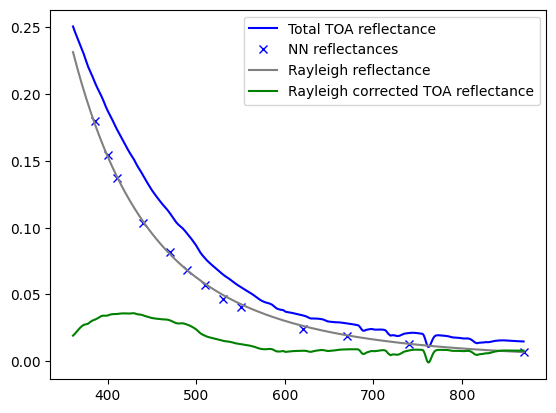

In [24]:
total_ref, ray_refoci, corr_ref, ref_nn=get_ref(device,modelpath,ref_oci,wl_oci,inda=1)

plt.plot(wl_oci,total_ref[300,260,:],c='b', label='Total TOA reflectance')
plt.plot(wl_nn, ref_nn[300,260,:],linestyle='none', marker='x',color='b',label='NN reflectances')
plt.plot(wl_oci,ray_refoci[300,260,:],c='gray', label='Rayleigh reflectance')
plt.plot(wl_oci,corr_ref[300,260,:],c='g',label='Rayleigh corrected TOA reflectance')
plt.legend()

#plt.title('clear sky pixels', fontsize=20)
# ax[1].plot(wavelengths,total_ref[150,400,:],c='b')
# ax[1].plot(wavelengths,ray_ref[150,400,:],c='gray')
# ax[1].plot(wavelengths,corr_ref[150,400,:],c='g')
# ax[1].set_title('Over cloudy pixels', fontsize=20)
#ax[1].legend()


### Rayleigh correction for multiangle measurements from SPEXone

- SPEXone has multiangle measurements.
- If OCI view has clouds, other angle from spexone can be cloud free supplement information.  

In [11]:
#For SPEXonne
anc_sp1='PACE.20240720T140430.L1C.ANC.5km.spex_width.nc'
spexfile='PACE_SPEXONE.20240720T140430.L1C.V2.5km.nc'

lat,lon,solzen,ref_sp1,wl_sp1,zen,az=l1c_data_reader1(spexfile)
o3,ps=anc_data_reader(anc_sp1)


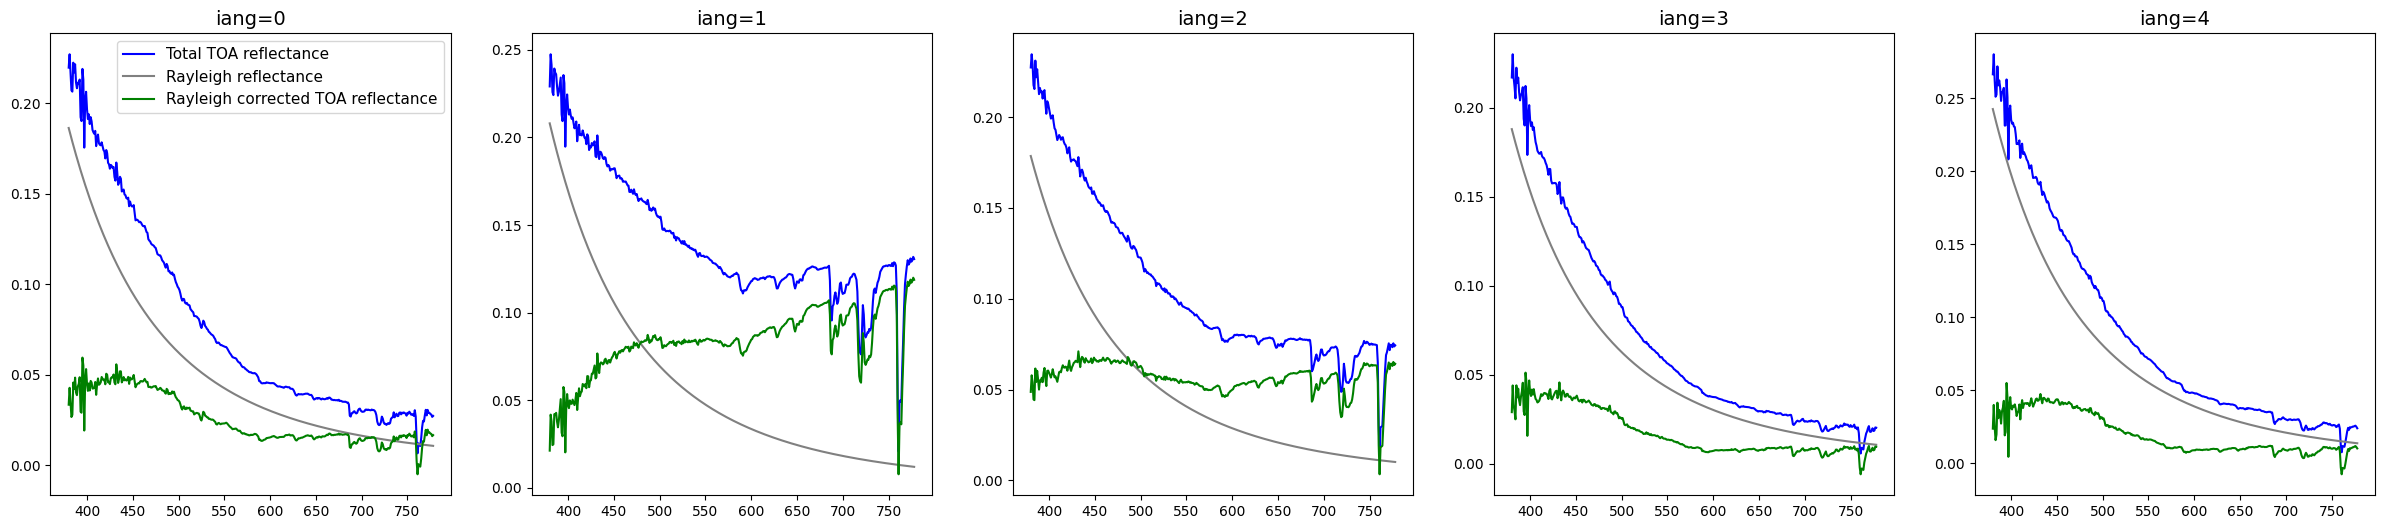

In [12]:
fig,ax=plt.subplots(1,5,figsize=[30,6])
for i in range(5):
    total_refs, ray_refs, corr_refs, ref_nn=get_ref(device,modelpath,ref_sp1,wl_sp1,i)
    ax[i].plot(wl_sp1,total_refs[300,16,:],c='b', label='Total TOA reflectance')
    ax[i].plot(wl_sp1,ray_refs[300,16,:],c='gray',label='Rayleigh reflectance')
    ax[i].plot(wl_sp1,corr_refs[300,16,:],c='g', label='Rayleigh corrected TOA reflectance')
    ax[i].set_title('iang='+str(i),fontsize=14)
    ax[0].legend(fontsize=11)



### Lets look at RGB plot and Rayleigh corrected RGB plot

Text(0.5, 1.0, 'RGB Image after Rayleigh correction')

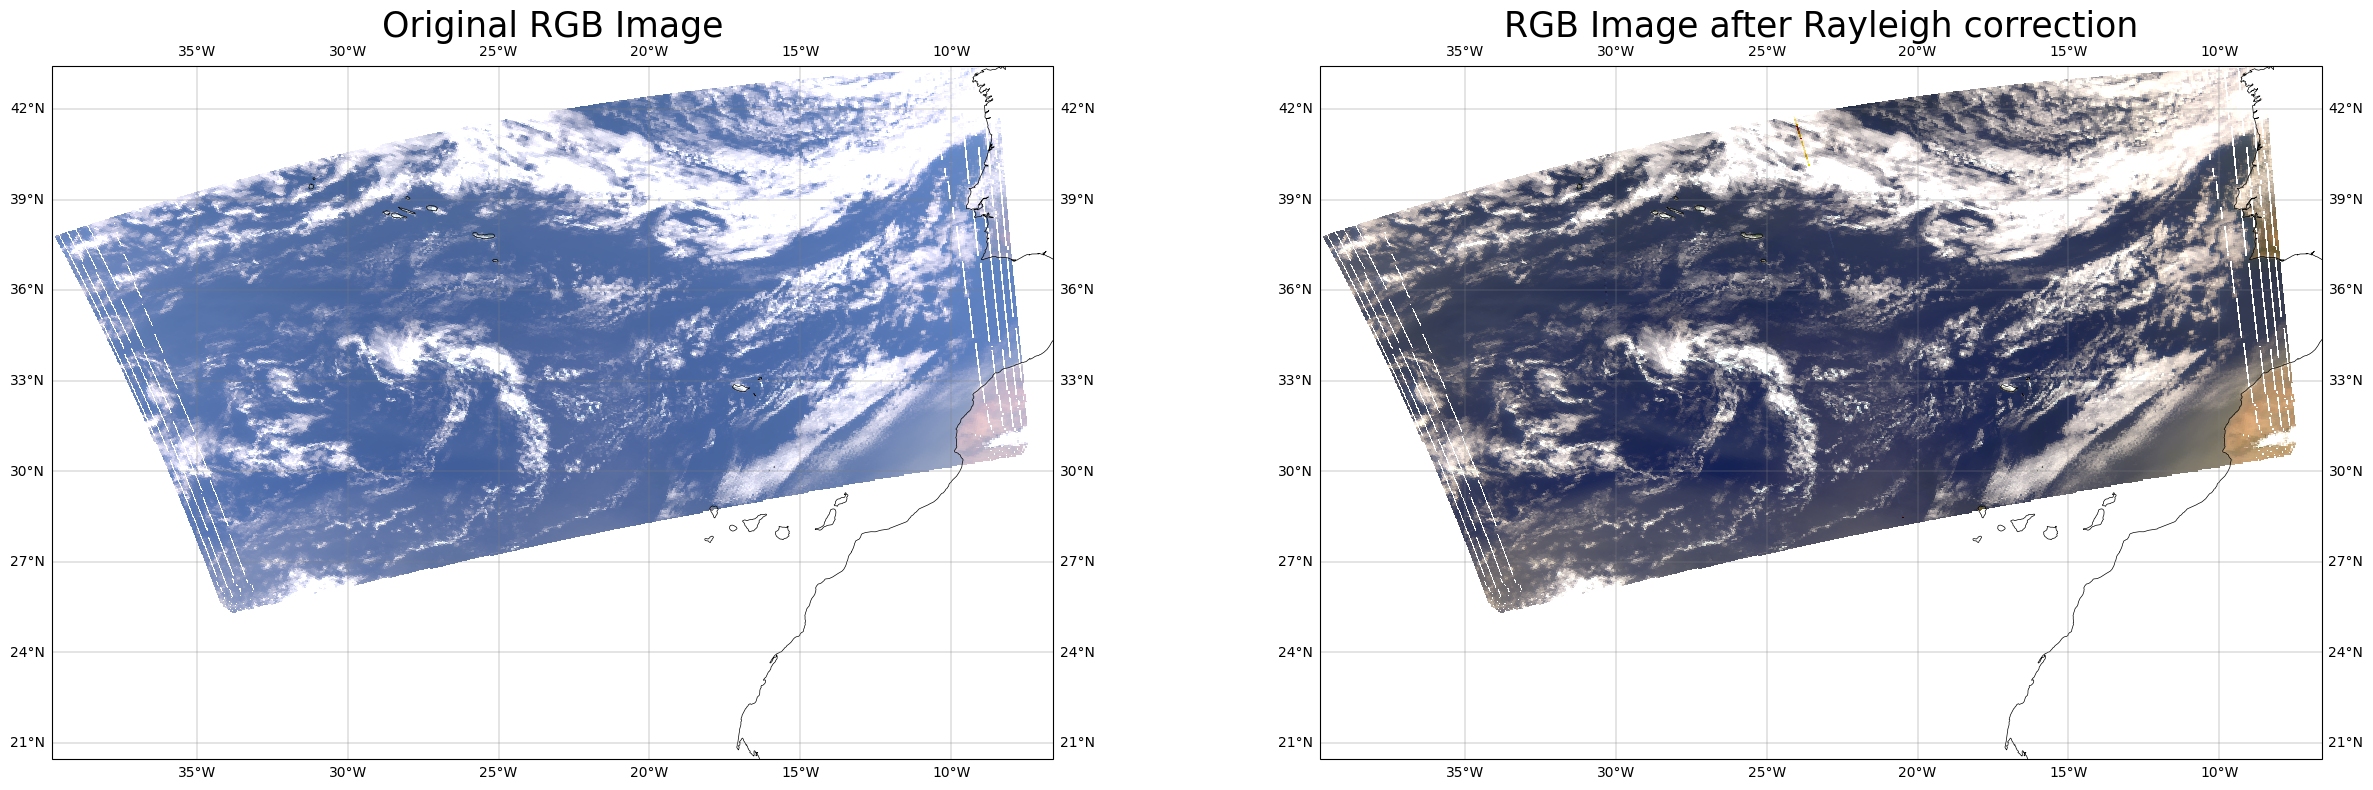

In [13]:
lat,lon,solzen,ref_oci,wl_oci,zen,az=l1c_data_reader(ocifile)
o3,ps=anc_data_reader(fileanc)

total_ref, ray_ref, corr_ref, ref_nn=get_ref(device,modelpath,ref_oci,wl_oci,inda=1)

fig,ax=plt.subplots(1,2,figsize=[30,9],subplot_kw={'projection': ccrs.PlateCarree()})
rgb_image(ax[0],total_ref,wl_oci)
rgb_image(ax[1],corr_ref,wl_oci)
ax[0].set_title('Original RGB Image',fontsize=25)
ax[1].set_title('RGB Image after Rayleigh correction',fontsize=25)

 ### RGB plot after removing non clear sky pixels
 - The reflectances on longer wavelengths (eg. 670) from clear sky pixels over ocean are very low.
 - non clear sky pixels are masked using threshold reflectance at 670 to be 0.15 for clear disctinction of ocean color.


Text(0.5, 1.0, 'RGB Image after Rayleigh correction')

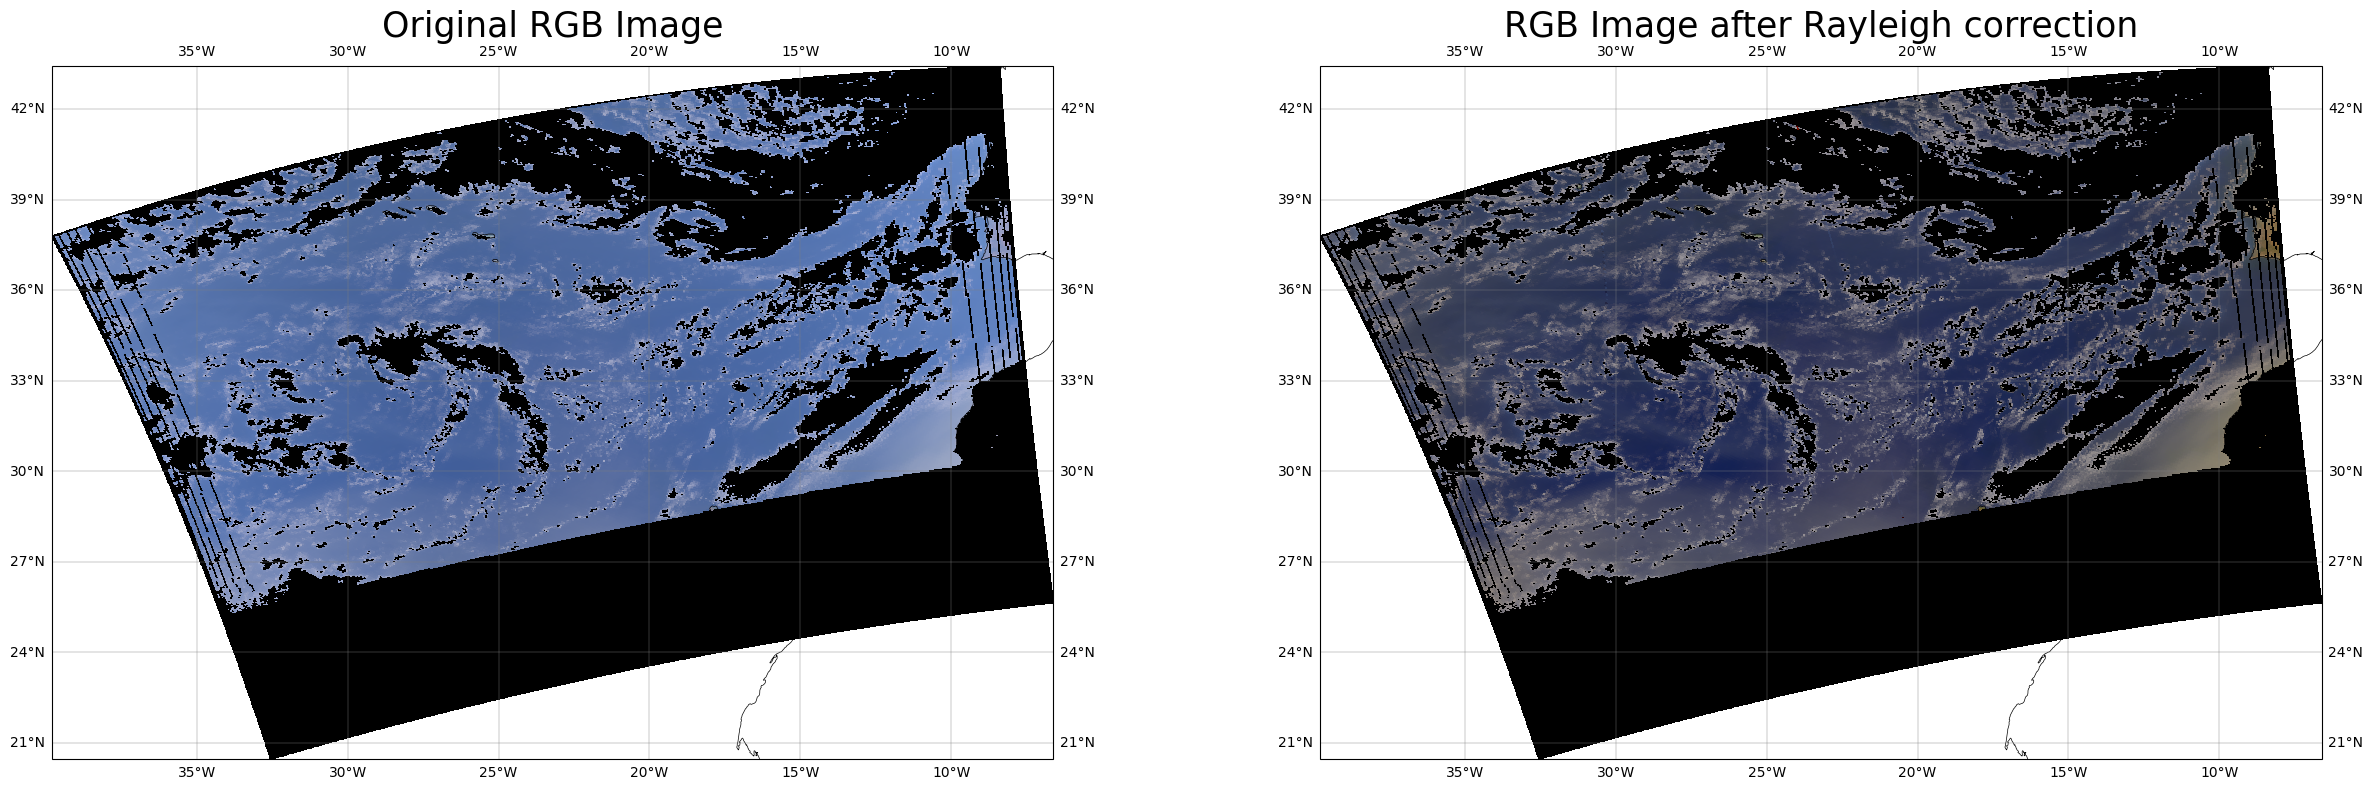

In [14]:
idx_670 = np.argmin(np.abs(wl_oci - 670))
# Extract reflectance at 670 nm
refl_670 = total_ref[:, :, idx_670]

# Define cloud threshold
clear_mask = refl_670 < 0.15

clear_total_ref=np.where(clear_mask[:, :, np.newaxis], total_ref, 0)
clear_corr_ref=np.where(clear_mask[:, :, np.newaxis], corr_ref, 0)

fig,ax=plt.subplots(1,2,figsize=[30,9],subplot_kw={'projection': ccrs.PlateCarree()})
rgb_image(ax[0],clear_total_ref,wl_oci)
rgb_image(ax[1],clear_corr_ref,wl_oci)
ax[0].set_title('Original RGB Image',fontsize=25)
ax[1].set_title('RGB Image after Rayleigh correction',fontsize=25)